# Sklearn: Ensemble Learning

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error as MSE, roc_auc_score as AUC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, VotingRegressor
from sklearn.ensemble import StackingClassifier, StackingRegressor
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier

np.set_printoptions(precision=4, suppress=True)
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

## 1. Overview
Classical Machine Learning algorithms are usually shown to be poor when handling real-world datasets. Models fit from these algorithms often suffer from two problems: high bias and high variance; such a model is called a *weak learner*. In this topic, we are going through some elegant techniques that combine multiple weak learners to form a powerful model, which produces an improved overall result. This is referred to generally as [Ensemble Learning](https://en.wikipedia.org/wiki/Ensemble_learning), a family of method has proven their effectiveness in many Machine Learing competitions.

### 1.1. Big picture
The branches of Ensemble Learning is summarized in the tree diagram below, where italic ones are specific algorithms.

- Stacking (1992)
    - Voting
    - Stacking
    - Blending
- Bagging: *RandomForest* (1995), *ExtraTrees* (2006)
- Boosting
    - Adaptive Boosting: *AdaBoost* (1997)
    - Gradient Boosting: *GBDT* (2001), *XGBoost* (2014), *LightGBM* (2016), *CatBoost* (2017), *NGBoost* (2018)

### 1.2. Bias-variance analysis
Let's say $x$ is a variable we think that may have a strong relationship on $y$, the variable we are trying to predict. When collecting data about $x$ and $y$, there are always some noises $\epsilon$ occuring. The relationship between $x$ and $y$ is written as:

$$y=f(x)+\epsilon$$

Predicting $y$ is the process of finding a function $\hat{f}$ that best models the true relationship $f$. The predicted value made by $\hat{f}$ is $\hat{y}=\hat{f}(x)$. To measure the error of a predictive model, a common metric is mean squared error $\mathbb{E}(y-\hat{y})^2$. It can be decomposed into:

$$\begin{aligned}
\text{TotalError}
&= \left(\mathbb{E}[\hat{y}]-f(x)\right)^2 + \mathbb{E}\left[\left(\hat{y}-\mathbb{E}[\hat{y}]\right)^2\right] + \sigma^2_\epsilon \\
&= \text{MSE}\left(\hat{y},f(x)\right) + \text{Var}(\hat{y}) + \text{Var}(\epsilon) \\
&= \text{Bias} + \text{Variance} + \text{IrreducibleError} \\
\end{aligned}$$

From this equation:
- Bias is the mean squared error between the predicted value $\hat{y}$ and the underlying true value we want to predict $f(x)$. So a model with high bias seems to be too simple to catch the underlying pattern $f$ in the data.
- Variance (of $\hat{y}$) shows how spread the predicted values are; the higher variance a model has, the more sensitive it is to noises. This is because noises make training data fluctuate, so that high variance is a sign of capturing noises.

A good model should have low bias and low variance, but practically it’s a challenge to achieve since there is always a trade-off between the two.

In [ ]:
from dsutil import np, pd, plt, ml
from sklearn import metrics

In [77]:
f = lambda a: np.sin(a)

np.random.seed(7)
e = np.random.normal(loc=0, scale=1, size=100)
x = np.random.uniform(0, 2*np.pi, size=100)
y_true = f(x)
y = y_true + e

x_func = np.linspace(0, 2*np.pi)
y_func_true = f(x_func)

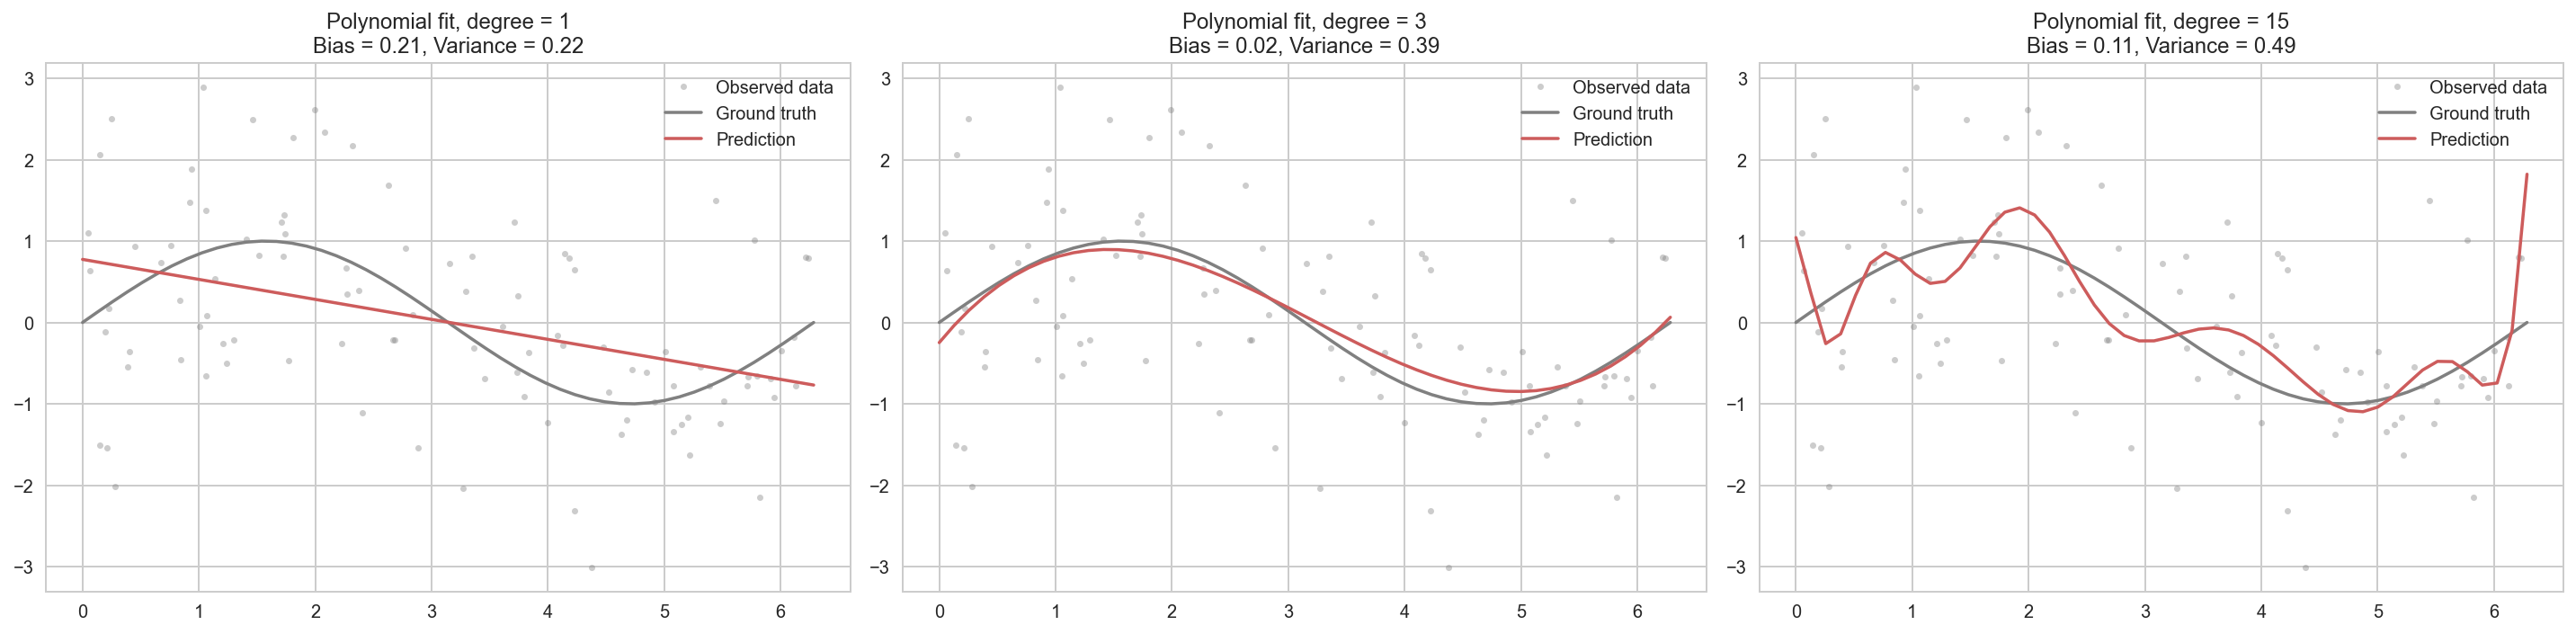

In [109]:
degrees = [1, 3, 15]
fig, ax = plt.subplots(figsize=(20,5), ncols=3, tight_layout=True)
for ax_sub, degree in zip(ax, degrees):
    # build model and predict
    coefs = np.polyfit(x, y, deg=degree)
    f_hat = lambda a: sum(a**(degree-i) * coefs[i] for i in range(degree+1))
    y_func_hat = f_hat(x_func)
    y_hat = f_hat(x)
    
    bias = metrics.mean_squared_error(y_true, y_hat)
    variance = np.var(y_hat)
    
    ax_sub.plot(x, y, '.', color='grey', alpha=0.4, label='Observed data')
    ax_sub.plot(x_func, y_func_true, color='grey', label='Ground truth')
    ax_sub.plot(x_func, y_func_hat, color='indianred', label='Prediction')
    ax_sub.set_title(f'Polynomial fit, degree = {degree}\nBias = {bias:.2f}, Variance = {variance:.2f}')
    ax_sub.legend()
plt.show()

#### Error reduction
In order to improve a model, we can try either to reduce bias or to reduce variance. But as state earlier, there is a trade-off, so it would be more practical to reduce one of the two error sources, while accept a small increase in the other. Ensemble Learning is the solution here, and I will do a quick analysis of how ensemble methods solve the issue.

The first method being metioned here is Bagging, it adds noises by subsetting the training dataset, so that the variance will reduce but the bias will increase a small amount. The second method is Boosting, it corrects error step-by-step and thus reduce bias a lot, but data leakage will increase variance a little bit.

## 2. Stacking

### 2.1. Voting
[Voting] (for classification) or [averaging] (for regression) is the simplest ensembling method. When doing voting for classification, there are two strategies can be applied: marjority voting on predicted results (hard voting) and taking argmax of the weighted average of predicted probabilities (soft voting).

[Voting]: https://scikit-learn.org/stable/modules/ensemble.html#voting-classifier
[averaging]: https://scikit-learn.org/stable/modules/ensemble.html#voting-regressor

In [ ]:
from dsutil import np, pd, ml
from sklearn import metrics

In [41]:
df_cancer = pd.read_csv('../data/breast_cancer.csv')
x = df_cancer.drop(columns='target')
y = df_cancer.target
x_train, x_test, y_train, y_test = ml.train_test_split(x, y, test_size=1/5, random_state=1)
x_train, x_valid, y_train, y_valid = ml.train_test_split(x_train, y_train, test_size=1/4, random_state=1)

In [42]:
clf1 = ml.SupportVectorClassifier(probability=True)
clf2 = ml.LinearClassifier(solver='liblinear')
clf3 = ml.DecisionTreeClassifier()

base_models = [clf1, clf2, clf3]
base_names = [(model.__class__.__name__, model) for model in base_models]
ensembler = ml.VotingClassifier(base_names, voting='soft')

In [43]:
for model in base_models + [ensembler]:
    model = model.fit(x_train, y_train)
    y_pred = model.predict_proba(x_test)[: ,1]
    auc = metrics.roc_auc_score(y_test, y_pred)
    print(f'AUC = {auc:.4f} [{model.__class__.__name__}]')

AUC = 0.9464 [SVC]
AUC = 0.9931 [LogisticRegression]
AUC = 0.8512 [DecisionTreeClassifier]
AUC = 0.9851 [VotingClassifier]


### 2.2. Stacking
[Stacking] technique organizes its members into two levels:
- Level 1, a number of *base models* are fitted to the training set. Each prediction made by one of these fitted base model is called a *latent feature*.
- Level 2, a *meta model* is trained using the latent features constructed in level 1.

The idea behind stacking is that each base model has an unique approach, it might discover some parts of the ground truth that other models do hot have. Combining them might utilize the their strengths and thus improve the overall quality. Note that Voting is a special case of Stacking, where the final combiner is a very simple model. In practice, the base models are often selected *heterogeneously*, and the meta model is often a simple linear model.

[Stacking]: https://scikit-learn.org/stable/modules/ensemble.html#stacked-generalization

#### With cross validation
The approach described earlier leaks the target when going from level 1 to level 2, so it is prone to overfitting. A solution has been implemented in Scikit-learn is combining it with cross validation.
- Step 1: Split the training data into $K$ folds.
- Step 2: Successively in $K$ rounds, use $K-1$ folds to train first-level models, then predict on the remaining unused fold.
- Step 3: For each model, contruct its complete latent feature by concatenating its predictions on $K$ folds.
- Step 4: Train the second-level model on the latent feature set constructed in step 3.

#### Blending
Blending is a simplified version of Stacking, it replaces cross validation with holdout validation. This technique gains popular recently because real world datasets are large, so training time is also an important aspect. However, people usually use *stacking* and *blending* interchangeably.

In [ ]:
from dsutil import np, pd, ml
from sklearn import metrics

In [39]:
df_cancer = pd.read_csv('../data/breast_cancer.csv')
x = df_cancer.drop(columns='target')
y = df_cancer.target
x_train, x_test, y_train, y_test = ml.train_test_split(x, y, test_size=1/5, random_state=1)
x_train, x_valid, y_train, y_valid = ml.train_test_split(x_train, y_train, test_size=1/4, random_state=1)

In [45]:
clf1 = ml.KNNClassifier()
clf2 = ml.SupportVectorClassifier(probability=True)
clf3 = ml.LinearClassifier(solver='liblinear')
clf4 = ml.DecisionTreeClassifier()

base_models = [clf1, clf2, clf3, clf4]
base_names = [(model.__class__.__name__, model) for model in base_models]
meta_model = ml.LinearClassifier()

ensembler = ml.StackingClassifier(base_names, meta_model)

In [46]:
for model in base_models + [ensembler]:
    model = model.fit(x_train, y_train)
    y_pred = model.predict_proba(x_test)[: ,1]
    auc = metrics.roc_auc_score(y_test, y_pred)
    print(f'AUC = {auc:.4f} [{model.__class__.__name__}]')

AUC = 0.9568 [KNeighborsClassifier]
AUC = 0.9775 [GaussianNB]
AUC = 0.9464 [SVC]
AUC = 0.9931 [LogisticRegression]
AUC = 0.8442 [DecisionTreeClassifier]
AUC = 0.9891 [StackingClassifier]


## 3. Bagging
[Bootstrap aggregating] (Bagging) uses averaging/voting method over a number of *homogeneous* weak models in order to reduce variance. Specifically, Bagging is divided into two parts: [bootstrapping] and [aggregating].

- Boostrapping: The entire dataset is performed random sampling with replacement on both rows and columns. This outputs a number of bootstraps where each of them is different from the others.
- Aggregating: after boostrap samples are generated, they are fit into the weak learners. All the model results will be combined by averaging (for regression) or voting (for classification).

A Bagging ensembler operates as a committee that outperforms any individual weak model. This wonderful effect - *the wisdom of crowds* - can be explained that weak models protect each other from their individual errors. If the members share the same behaviors, they also make the same mistakes. Therefore, the low correlation between weak models is the key. Note that the Bagging method requires the initial sample to be large enough for the bootstrapping step to be statistical significant.

[Bootstrap aggregating]: https://scikit-learn.org/stable/modules/ensemble.html#bagging-meta-estimator
[bootstrapping]: https://en.wikipedia.org/wiki/Bootstrapping_(statistics)
[aggregating]: https://en.wikipedia.org/wiki/Aggregate_function>

### 3.1. Random Forest
[Random Forest] is the implementation of Bagging method on Decision Trees. It can be easily parallelized, does not requires too much hyperparameters tuning and has a decent prediction power. Random Forest is a very popular algorithm, before Boosting methods take the crown. The <code style="font-size:13px">[RandomForestClassifier]</code> and
<code style="font-size:13px">[RandomForestRegressor]</code> classes have the following Bagging hyperparameters (ones inherited from Decision Tree are not mentioned):
- <code style="font-size:13px">n_estimators</code>: the number of trees in the forest, defaults to *100*. Control the complexity of the algorithm. Try increasing this when the model is underfitting, but it will take a longer training time.
- <code style="font-size:13px">max_features</code>: the ratio of features used in each tree, defaults to *auto* (square root of *n_feature*). A lower value increases bias and reduces variance.
- <code style="font-size:13px">max_samples</code>: the ratio of instances used in each tree, defaults to *None* (100% of *n_sample*). A lower value increases bias and reduces variance.

[Random Forest]: https://en.wikipedia.org/wiki/Random_forest
[RandomForestClassifier]: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
[RandomForestRegressor]: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

### 3.2. Extra Trees
Besides Random Forest, Sickit-learn also develops a quite similar algorithm, Extremely Randomized Trees (Extra Trees for short). Instead of finding the split with highest information gain at each step, this method goes one step further in randomness by selecting the best candidate among a number of randomly-generated cut points. The
<code style="font-size:13px">[ExtraTreesClassifier]</code> and
<code style="font-size:13px">[ExtraTreesRegressor]</code> classes have same hyperparameters as in Random Forest, there are only some small differences in their default values.
    
[ExtraTreesClassifier]: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html
[ExtraTreesRegressor]: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html

### 3.3. Implementation

In [ ]:
from dsutil import np, pd, ml
from sklearn import metrics

In [39]:
df_cancer = pd.read_csv('../data/breast_cancer.csv')
x = df_cancer.drop(columns='target')
y = df_cancer.target
x_train, x_test, y_train, y_test = ml.train_test_split(x, y, test_size=1/5, random_state=1)
x_train, x_valid, y_train, y_valid = ml.train_test_split(x_train, y_train, test_size=1/4, random_state=1)

In [47]:
base_model = ml.LinearClassifier(solver='liblinear', class_weight={0:1, 1:10})
ensembler = ml.BaggingClassifier(base_model, 10, random_state=7)

model1 = ml.RandomForestClassifier(n_estimators=20, random_state=7)
model2 = ml.ExtraTreesClassifier(n_estimators=20, random_state=7)

In [48]:
models = [base_model, ensembler, model1, model2]
for model in models:
    model = model.fit(x_train, y_train)
    y_pred = model.predict_proba(x_test)[: ,1]
    auc = metrics.roc_auc_score(y_test, y_pred)
    print(f'AUC = {auc:.4f} [{model.__class__.__name__}]')

AUC = 0.9845 [LogisticRegression]
AUC = 0.9897 [BaggingClassifier]
AUC = 0.9688 [RandomForestClassifier]
AUC = 0.9749 [ExtraTreesClassifier]


## 4. Boosting
[Boosting] works in the same spirit as Bagging: it also build a group of *homogeneous* models to obtain a more powerful predictor. The difference is that Boosting trains weak models sequentially while Bagging perform the training independently. The idea behind Boosting is to fit models iteratively such that the training of each model depends on the previous ones. Using this strategy, badly handled observations in the earlier steps will be taken care better in the later steps. Since the Boosting method puts its efforts on important cases, we end up have a strong learner with lower bias.

In many competitions, Boosting methods used on Decision Trees are so effective for tabular datasets and is widely used by top competitors. For the rest of this article, we will take a deep dive into a bunch of interesting Boosting algorithms. To start off, let's take a quick overview of two Boosting approaches, Adaptive Boosting and Gradient Boosting. They do both train trees consequently, but behave differently. We first denote: $\eta$ - the learning rate, $T$ - the number of iterations, $f^{(t)}$ and $f^{(t)}(\mathbf{X})$ - the tree number $t$ and its predicted value for $t=1,2,\dots,T$.

*Adaptive Boosting*
- Train $f^{(1)}$
- Train $f^{(2)}$ base on $f^{(1)}$
- Train $f^{(3)}$ base on $f^{(2)}$
- ...
- Train $f^{(T)}$ base on $f^{(T-1)}$
- Scale each tree by a coefficient $\eta$ and predict
$\hat{\mathbf{y}}\leftarrow\eta f^{(1)}(\mathbf{X})+\eta f^{(2)}(\mathbf{X})+\dots+\eta f^{(T)}(\mathbf{X})$

*Gradient Boosting*
- Intialize $\hat{\mathbf{y}}^{(0)}$
- Train $f^{(1)}$ base on $\hat{\mathbf{y}}^{(0)}$ and compute $\hat{\mathbf{y}}^{(1)}=\hat{\mathbf{y}}^{(0)}+\eta f^{(1)}(\mathbf{X})$
- Train $f^{(2)}$ base on $\hat{\mathbf{y}}^{(1)}$ and compute $\hat{\mathbf{y}}^{(2)}=\hat{\mathbf{y}}^{(1)}+\eta f^{(2)}(\mathbf{X})$
- ...
- Train $f^{(T)}$ base on $\hat{\mathbf{y}}^{(T-1)}$ and compute $\hat{\mathbf{y}}^{(T)}=\hat{\mathbf{y}}^{(T-1)}+\eta f^{(T)}(\mathbf{X})$
- Predict $\hat{\mathbf{y}}\leftarrow\hat{\mathbf{y}}^{(T)}$

[Boosting]: https://en.wikipedia.org/wiki/Boosting_(machine_learning)

### 4.1. Adaptive Boosting
[Adaptive Boosting], published in the paper
[A Decision-Theoretic Generalization of On-Line Learning and an Application to Boosting](https://www.sciencedirect.com/science/article/pii/S002200009791504X?via%3Dihub)
(1997), was originally designed for binary classification problems. This method can be used to boost any algorithm, but Decision Tree is always the go-to choice. More specifically, Decision Trees used here are very shallow, they only have one root and two leaves, explaining why they are also called Decision Stumps.

[Adaptive Boosting]: https://en.wikipedia.org/wiki/AdaBoost

In [ ]:
from dsutil import np, pd, ml, plt
from sklearn import metrics

#### Algorithm
*Input:*
- A dataset having $N$ observations $(\mathbf{X},\mathbf{y})=\{(\mathbf{s}_n,y_n)\}_{n=1}^N$ where $y_n\in\{-1,1\}$
- The number of weak models, $T$
- The learning rate, $\eta$

*Step 1.* Initialize the weight for each observation: $w_n^{(1)}=1/N$.

*Step 2.* For each iteration number $t$ where $t=1,2,\dots,T$:

   - Train a weak model $f^{(t)}$ that minimizes the sum of weights over misclassifications, represented by the error:
   
   $$\epsilon^{(t)}=\sum_{n=1}^{N}{w_n^{(t)}\left[\hat{y}_n\neq y_n\right]}$$

   - Calculate $\alpha^{(t)}$ the amount of say for the current weak classifier; deciding how much $f^{(t)}$ will contribute in the final prediction. This calculation rewards $f^{(t)}$ a very high influence if its total error is low and penalizes $f^{(t)}$ a negative influence for a high total error.
   
   $$\alpha^{(t)}=\frac{\eta}{2}\,\log{\frac{1-\epsilon^{(t)}}{\epsilon^{(t)}}}$$
   
   - Update sample weights for the next iteration so that: the weights of the correctly classied samples decrease $\exp{(\alpha^{(t)})}$ times and the weights of misclassifications increase the same amount. Notice that the term $-\hat{y}_n y_n$ equals to $1$ if the prediction is correct and equals to $-1$ if the prediction is incorrect.
   
   $$w_n^{(t+1)}=w_n^{(t)}\exp{\left(-\hat{y}_n y_n\alpha^{(t)}\right)}$$
   
   - Normalize new weights so that they add up to $1$. This step is required to make the calculation of $\alpha^{(t+1)}$ meaningful. At this step, some implementations resample the dataset so that the distribution of observations follows the newly calculated weights.

*Step 3.* Build an additive strong model that performs weighted voting over $T$ weak learners; this is model outputs the prediction of the algorithm, $\hat{\mathbf{y}}$. The formula uses the notation $\text{sign}(\bullet)$, indicating the [sign function](https://en.wikipedia.org/wiki/Sign_function).

$$\hat{\mathbf{y}}=\text{sign}\left(\sum_{t=1}^T\alpha^{(t)} f^{(t)}(\mathbf{X})\right)$$

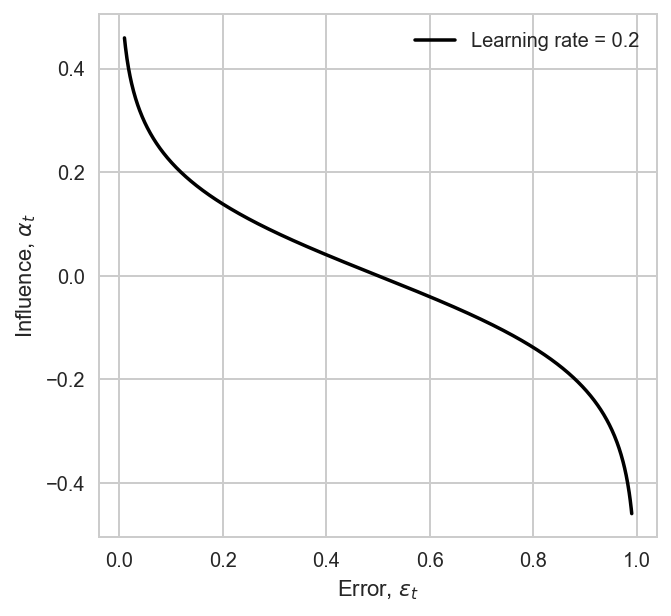

In [2]:
eta = 0.2
x = np.linspace(0.01, 0.99, 1000)
y = eta * 1/2 * np.log(1/x - 1)

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(x, y, 'k', label=fr'Learning rate = {eta}')
ax.axis('scaled')
ax.set_xlabel(r'Error, $\epsilon_t$')
ax.set_ylabel(r'Influence, $\alpha_t$')
ax.legend()
plt.show()

#### Implementation
The classes
<code style="font-size:13px">[AdaBoostClassifier]</code> and
<code style="font-size:13px">[AdaBoostRegressor]</code> have the following Boosting hyperparameters:
- <code style="font-size:13px">base_estimator</code>: the algorithm to be boosted, defaults to *None* (Decision Tree with max depth of 1).
- <code style="font-size:13px">n_estimators</code>: the number of boosting stages ($T$), defaults to *50*.
- <code style="font-size:13px">learning_rate</code>: the learning rate ($\eta$), defaults to *1*.
    
[AdaBoostClassifier]: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
[AdaBoostRegressor]: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html

In [39]:
df_cancer = pd.read_csv('../data/breast_cancer.csv')
x = df_cancer.drop(columns='target')
y = df_cancer.target
x_train, x_test, y_train, y_test = ml.train_test_split(x, y, test_size=1/5, random_state=1)
x_train, x_valid, y_train, y_valid = ml.train_test_split(x_train, y_train, test_size=1/4, random_state=1)

In [49]:
base_model = ml.DecisionTreeClassifier(max_depth=1)
ensembler = ml.AdaBoostClassifier(base_model, n_estimators=50, learning_rate=1)

In [50]:
models = [ensembler]
for model in models:
    model = model.fit(x_train, y_train)
    y_pred = model.predict_proba(x_test)[: ,1]
    auc = metrics.roc_auc_score(y_test, y_pred)
    print(f'AUC = {auc:.4f} [{model.__class__.__name__}]')

AUC = 0.9828 [AdaBoostClassifier]


### 4.2 Gradient Boosting
[Grandient Boosting] is another boosting strategy beside Adaptive Boosting. The idea of this method is mostly inspired by [Gradient Descent], thus the name Gradient Boosting. Just like other ensembling methods, this algorithm works best on Decision Trees and becomes the foundation for its modern variants such as XGBoost, LightGBM and CatBoost.

Gradient Boosting Trees was originally designed for regression problems. For classification, we use regression approach to predict [log of the odds].

[Grandient Boosting]: https://en.wikipedia.org/wiki/Gradient_boosting
[Gradient Descent]: https://en.wikipedia.org/wiki/Gradient_descent
[log of the odds]: https://en.wikipedia.org/wiki/Logit

In [ ]:
from dsutil import np, pd, ml, plt
from sklearn import metrics

#### Algorithm
*Input:*
- A dataset having $N$ labeled observations $(\mathbf{X},\mathbf{y})=\{(\mathbf{s}_n,y_n)\}_{n=1}^N$
- The number of weak models, $T$
- The learning rate, $\eta$
- A [differentiable] loss function $\mathcal{L}(\hat{\mathbf{y}})$ ([squared error] is a popular choice)

*Step 1.* Initialize the prediction as a constant. Since this is the very first prediction and will be updated step-by-step, we denote this value $\hat{\mathbf{y}}^{(0)}$. When the loss function is MSE, this value is nothing but the mean of $\mathbf{y}$.

$$\hat{\mathbf{y}}^{(0)}=\arg\min\sum_{n=1}^N \mathcal{L}(\hat{y}_n)$$

*Step 2.* For $t=1$ to $T$:

   - Compute the psuedo-residual $r_n^{(t)}$ equals to the negative gradient of the loss function with respect to the prediction of the iteration $t-1$. When MSE is used, this term is proportional to the actual residual, $y_n-\hat{y}_n^{(t-1)}$. In general, we call it pseudo-residual which allows plugging in different loss functions.
   
   $$r_n^{(t)}=-g_n^{(t)}=-\frac{\partial\mathcal{L}(\hat{y}_n^{(t-1)})}{\partial \hat{y}_n^{(t-1)}}$$

   - Fit a weak learner (regression tree) $f^{(t)}$ using the training set $(\mathbf{X},\mathbf{r}^{(t)})$. This step results in a tree with $M$ leaf nodes; meaning the input space is split into $M$ [disjoint] regions, each region is denoted $R_m\;(m=1,2,\dots,M)$. Trees in this step are not restricted to be stumps as in AdaBoost. Compute $f^{(t)}(\mathbf{X})$, the predicted value for the model $f^{(t)}$ so that it minimizes the loss function at the current step.
   
   $$f^{(t)}(\mathbf{X})=\underset{f}{\arg\min}\sum_{n=1}^{N}{\mathcal{L}\left(\hat{y}_n^{(t-1)}+f(\mathbf{s}_n)\right)}$$
   
   - Use first-order [Taylor approximation]: $f(x)\approx f(a)+f'(a)(x-a)$ to estimate the loss function evaluated at step $t-1$. Here, $x$ corresponds to $\hat{y}_n^{(t-1)}+f(\mathbf{s}_n)$ and $a$ corresponds to $\hat{y}_n^{(t-1)}$. Using the notation $g_n^{(t)}$ defined earlier, we have:
   $\mathcal{L}\left(\hat{y}_n^{(t-1)}+f(\mathbf{s}_n)\right)\approx\mathcal{L}\left(\hat{y}_n^{(t-1)}\right)+g_n^{(t)}f(\mathbf{s}_n)$.
   We can prove that $f^{(t)}(\mathbf{X})$ is proportional to the negative gradient as follows. When MSE is chosen, is simply computes the average residual in each leaf.
   
   $$\begin{aligned}
   f^{(t)}(\mathbf{X})
   &\approx \underset{f}{\arg\min} \sum_{n=1}^{N}\mathcal{L}\left(\hat{y}_n^{(t-1)}\right)+g_n^{(t)}f(\mathbf{s}_n) \\
   &= \underset{f}{\arg\min} \sum_{n=1}^{N}g_n^{(t)}f(\mathbf{s}_n) \propto -g_n^{(t)}
   \end{aligned}$$
   
   - Compute the predicted value up to the current step, $\hat{\mathbf{y}}^{(t)}$. Since we are adding negative gradient $-g_n^{(t-1)}$ scaled by the learning rate $\eta$ step-by-step, this can be considered a Gradient Descent process.
   
   $$\hat{\mathbf{y}}^{(t)}=\hat{\mathbf{y}}^{(t-1)}+\eta f^{(t)}(\mathbf{X})$$
   
*Step 3*. Take the last round's predicted value as the final prediction: $\hat{\mathbf{y}}\leftarrow \hat{\mathbf{y}}^{(T)}$. Note that in Gradient Boosting, the prediction at each iteration $\hat{\mathbf{y}}^{(t)}$ has taken into account all weak learners up to the current step. This behaviour is not like Adaptive Boosting, in which the strong model is only built once all weak leaners was trained successfully.

[differentiable]: https://en.wikipedia.org/wiki/Differentiable_function
[squared error]: https://en.wikipedia.org/wiki/Residual_sum_of_squares
[disjoint]: https://en.wikipedia.org/wiki/Disjoint_sets
[Taylor approximation]: https://en.wikipedia.org/wiki/Taylor_series

#### Implementation
The
<code style="font-size:13px">[GradientBoostingClassifier]</code> and
<code style="font-size:13px">[GradientBoostingRegressor]</code>
classes are the original impelementation of Gradient Boosting Trees. After a while,
<code style="font-size:13px">[HistGradientBoostingClassifier]</code> and
<code style="font-size:13px">[HistGradientBoostingRegressor]</code>
which use histogram-based split finding were introduced. The later implementation is significantly faster for big datasets. The common hyperparameters of these algorithms are:
- <code style="font-size:13px">loss</code>: the type of loss function, defaults to *deviance* (classification) and *squared_error* (regression).
- <code style="font-size:13px">n_estimators</code>: the number of boosting stages ($T$), defaults to *100*.
- <code style="font-size:13px">learning_rate</code>: the learning rate ($\eta$), defaults to *0.1*.
- <code style="font-size:13px">max_features</code>: the ratio of features used in each tree, defaults to *auto* (square root of *nFeature*). A lower value increases bias and reduces variance.
- <code style="font-size:13px">subsample</code>: the ratio of instances used in each tree, defaults to *1* (100% of *nSample*). A lower value increases bias and reduces variance.
- <code style="font-size:13px">criterion</code>: the measure of quality of splits, defaults to *friedman_mse*.
    
[GradientBoostingClassifier]: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
[GradientBoostingRegressor]: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
[HistGradientBoostingClassifier]: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html
[HistGradientBoostingRegressor]: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html

In [39]:
df_cancer = pd.read_csv('../data/breast_cancer.csv')
x = df_cancer.drop(columns='target')
y = df_cancer.target
x_train, x_test, y_train, y_test = ml.train_test_split(x, y, test_size=1/5, random_state=1)
x_train, x_valid, y_train, y_valid = ml.train_test_split(x_train, y_train, test_size=1/4, random_state=1)

In [40]:
model = ml.GradientBoostingClassifier(random_state=7)
model = model.fit(x_train, y_train)
y_pred = model.predict_proba(x_test)[: ,1]
auc = metrics.roc_auc_score(y_test, y_pred)
print(f'AUC = {auc:.4f} [{model.__class__.__name__}]')

AUC = 0.9729 [GradientBoostingClassifier]
AUC = 0.9831 [HistGradientBoostingClassifier]


## Resources
- *scikit-learn - [Scikit-learn's ensemble methods](https://scikit-learn.org/stable/modules/ensemble.html)*
- *medium - [Ensemble methods: bagging, boosting and stacking](https://towardsdatascience.com/ensemble-methods-bagging-boosting-and-stacking-c9214a10a205)*
- *cseweb.ucsd - [A short introduction to Boosting](https://cseweb.ucsd.edu/~yfreund/papers/IntroToBoosting.pdf)*

---
*&#9829; By Quang Hung x Thuy Linh &#9829;*